In [2]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.regularizers import l1_l2, l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from tensorflow.python.keras import backend as K
from tensorflow.keras.preprocessing.image  import array_to_img,img_to_array

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

2024-05-20 16:16:02.389528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data import as for the classification model:

In [3]:
from sklearn.model_selection import train_test_split

# Loading the training data
train_df = pd.read_csv('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

# Loading the test data
# test_df = pd.read_csv('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/test/test_set.csv', index_col="Id")
# test_df["img"] = [np.load('/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
# test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
# print("The test set contains {} examples.".format(len(test_df)))

#take first 20 columns the values of 0 and 1 of the dataframe as labels
labels_df = train_df.iloc[:, :20]
train_labels = labels_df.values

# Define a function to resize images
def resize_images(img_series, size=(224, 224)):
    return img_series.apply(lambda img: cv2.resize(img, size))

# Resize and convert the images to a numpy array
train_images = np.stack(resize_images(train_df["img"]).values)
#test_images = np.stack(resize_images(test_df["img"]).values)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=0)

# Normalization
print(np.max(X_train))
X_train = X_train / 255
X_val  = X_val / 255
print(np.max(X_train))

The training set contains 749 examples.
255
1.0


Code below copied from Pretrained_classification:

In [9]:
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.applications import InceptionResNetV2

base_model = InceptionResNetV2(include_top=False,
                                      weights="imagenet",     # "imagenet" when transfer learning
                                      input_shape=(224, 224, 3),
                                      pooling = "avg"
                                      )
x = base_model.output
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)

predictions = Dense(20, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.load_weights("/Users/perrinebamps/Documents/GitHub/Computer_Vision_Group_Assignment_2/InceptionResNetV2_augmented.h5")

2024-05-20 16:18:49.598458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The code below has been copied (and adapted for size of images and model) from this webpage: https://medium.com/mindboard/generating-adversarial-samples-in-keras-tutorial-f881ac836246

TO DO: Change at least the comments, and maybe some other variable name
& We may want to cite the source?


In [41]:
#custom activation function for keeping adversarial pixel values between 0.0 and 1.0
def clip(x):
    return K.clip(x, 0.0, 1.0)

#custom loss funciton for non-targeted misclassification
def negative_categorical_crossentropy(yTrue,yPred):
    return 0.0 - K.categorical_crossentropy(yTrue,yPred)

#add custom objects to dictionary
get_custom_objects().update({'clip': Activation(clip)})
get_custom_objects().update({'negative_categorical_crossentropy': negative_categorical_crossentropy})

#function for generating an adversarial example given a base image, adversarial class target, classifier, and regularization type
def generate_adversary(img,target,model,regularization,loss_function):
    
    #input for base image
    image = Input(shape=(224,224,3),name='image')
    #unit input for adversarial noise
    one = Input(shape=(1,),name='unity')

    #layer for learning adversarial noise to apply to image
    noise = Dense(224 * 224 * 3,activation = None,use_bias=False,kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    #reshape noise in shape of image
    noise = Reshape((224, 224, 3),name='reshape')(noise)
    
    #add noise to image
    net = Add(name='add')([noise,image])
    #clip values to be within 0.0 and 1.0
    net = Activation('clip',name='clip_values')(net)
    
    #feed adversarial image to trained MNIST classifier
    outputs = model(net)

    adversarial_model = Model(inputs=[image,one], outputs=outputs)
    #freeze trained MNIST classifier layers
    adversarial_model.layers[-1].trainable = False
    
    adversarial_model.compile(optimizer='sgd', loss=loss_function, metrics=[categorical_accuracy])

    #target adversarial classification
    target_vector = np.zeros(20)
    target_vector[target] = 1.
    
    #callback for saving weights with smallest loss
    checkpoint = ModelCheckpoint('/Users/perrinebamps/Documents/adversarial_weights.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True,
                                 mode='auto', save_freq='epoch')#period=1)
    #train adversarial image
    adversarial_model.fit(x={'image':np.expand_dims(img, axis=0),'unity':np.ones(shape=(1, 1))},y=target_vector.reshape(1,-1),epochs=100,verbose=0,
                         callbacks=[checkpoint])
    #restore best weights
    adversarial_model.load_weights('/Users/perrinebamps/Documents/adversarial_weights.h5')
    
    #quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((224, 224, 3)) * 255.) / 255.
 
    #add trained weights to original image and clip values to produce adversarial image
    adversarial_img = np.clip(img.reshape((224, 224, 3)) + quantized_weights, 0., 1.)
    
    #display adversarial image
    #plt.imshow(adversarial_img,vmin=0., vmax=1.)
    #plt.show()
    #classify adversarial image
    #adversarial_prediction = model.predict(adversarial_img.reshape((1, 224, 224, 3)))
    #ind = adversarial_prediction.argmax()
    #print(labels_df.columns.tolist()[ind])
    
    return adversarial_img, quantized_weights



In [ ]:
# Test with one image:
img = X_train[1]
tgt = y_train[1].argmax()

adv_img = generate_adversary(img,2,model,l1(0.01),'categorical_crossentropy')

Included in a loop so it works for any given image: apply adversarial attack only on class 7 replacing to class 2:

In [78]:
def classify_image(image):
    predictions = model.predict(image.reshape((1, 224, 224, 3)))
    return predictions

def classify_with_adversarial(image):
    # Classify the image
    predictions = classify_image(image)

    # Check if the image is classified as sheep (assuming sheep class is index 5)
    if predictions.argmax() == 7:
        # Generate adversarial example targeting bird class (assuming bird class is index 2)
        adv_img, adv_weights = generate_adversary(image, 2, model, l1(0.01), 'categorical_crossentropy')
        
        # Re-classify the adversarial image
        predictions = classify_image(adv_img)

        return predictions, adv_img, adv_weights
    
    else:
        return predictions, image, np.zeros((224, 224, 3))

Example for an image of the class attacked:

1/1 [==============================] - 0s 325ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 240ms/step


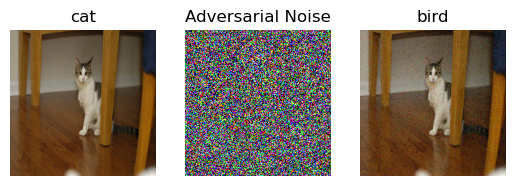

In [79]:
img_true = X_train[3]
ind_true = y_train[3].argmax()
predictions, img_adv, noise_adv = classify_with_adversarial(img_true)
ind_adv = predictions.argmax()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(img_true)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[0].axis('off')
axs[1].imshow(np.clip(noise_adv*100, 0, 1))   # (Noise * 100) to amplify it and improve visibility.
axs[1].set_title("Adversarial Noise")
axs[1].axis('off')
axs[2].imshow(img_adv)
axs[2].set_title(labels_df.columns.tolist()[ind_adv])
axs[2].axis('off')
plt.show()


Example for an image of another class:

1/1 [==============================] - 1s 544ms/step


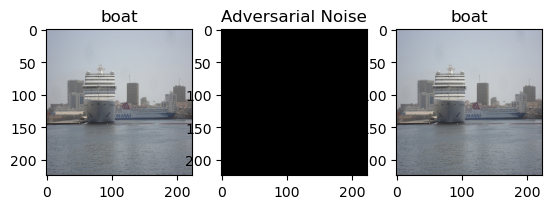

In [80]:
img_true = X_train[2]
ind_true = y_train[2].argmax()
predictions, img_adv, noise_adv = classify_with_adversarial(img_true)
ind_adv = predictions.argmax()

fig, axs = plt.subplots(1, 3)
axs[0].imshow(img_true)
axs[0].set_title(labels_df.columns.tolist()[ind_true])
axs[1].imshow(np.clip(noise_adv*100, 0, 1))   # (Noise * 100) to amplify it and improve visibility & clip to color range.
axs[1].set_title("Adversarial Noise")
axs[2].imshow(img_adv)
axs[2].set_title(labels_df.columns.tolist()[ind_adv])
plt.show()